# Convolution Neural Networks: CIFAR-10 Dataset
### Please let me know if you found any errors, Email me at qiang.sun@utoronto.ca
#### I strongly encourage to buy Google Colab Pro.

This assignment uses the classic [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset, which is a labeled subset of the 80 million tiny images dataset. It was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton.

In [ ]:
###checking if we are getting GPU in colab
###if not, Runtime → Change runtime type and Set Hardware accelerator to GPU
# !nvidia-smi

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as T

import matplotlib.pyplot as plt
import numpy as np

# We are gonna to define all the functions so that we can train the model better later
### Data Loader and evaluation [Fill in where you have raise NotImplementedError("Fill me in")]
---




In [2]:
### data loaders (CIFAR-10) ####
def get_cifar10_loaders(batch_size=128, num_workers=2, val_size=5000, seed=42):
    # CIFAR-10 mean/std (common)
    mean = (0.4914, 0.4822, 0.4465)
    std  = (0.2470, 0.2435, 0.2616)

    # Data augmentation ONLY for training
    train_tfms = T.Compose([
        # Random crop with padding for spatial augmentation
        T.RandomCrop(32, padding=4),
        # Random horizontal flip for left-right invariance
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize(mean, std),
    ])

    # No augmentation for val/test
    eval_tfms = T.Compose([
        T.ToTensor(),
        T.Normalize(mean, std),
    ])

    # Load the official CIFAR10 train set twice with different transforms
    full_train_for_train = torchvision.datasets.CIFAR10(
        root="./data", train=True, download=True, transform=train_tfms
    )
    full_train_for_eval = torchvision.datasets.CIFAR10(
        root="./data", train=True, download=True, transform=eval_tfms
    )

    testset = torchvision.datasets.CIFAR10(
        root="./data", train=False, download=True, transform=eval_tfms
    )

    # Split indices deterministically
    n_total = len(full_train_for_train)  # 50,000
    n_val = val_size
    n_train = n_total - n_val

    g = torch.Generator().manual_seed(seed)
    train_subset, val_subset = random_split(full_train_for_train, [n_train, n_val], generator=g)

    # IMPORTANT: val subset should use eval transforms (no augmentation)
    # So we re-create val subset with the same indices but using full_train_for_eval
    val_subset = torch.utils.data.Subset(full_train_for_eval, val_subset.indices)

    trainloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True,
                             num_workers=num_workers, pin_memory=True)
    valloader = DataLoader(val_subset, batch_size=batch_size, shuffle=False,
                           num_workers=num_workers, pin_memory=True)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False,
                            num_workers=num_workers, pin_memory=True)

    return trainloader, valloader, testloader


### Model Eval
---

In [3]:
###Early Stopping Helper
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float("inf")
        self.counter = 0

    def step(self, val_loss):
        # returns True if we should stop
        improved = val_loss < (self.best_loss - self.min_delta)
        if improved:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience


###Eval
@torch.no_grad()
def evaluate(model, loader, device, criterion):
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)

        loss_sum += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return loss_sum / total, correct / total

## Train your model

*   Please fill in the blanks


In [4]:
def train_with_early_stopping_adamw(
    model,
    trainloader,
    valloader,
    device,
    epochs=50,
    lr=3e-4,
    weight_decay=1e-2,
    patience=3,
    save_path="best_cifar10_simplecnn.pt",
):
    criterion = nn.CrossEntropyLoss()

    # AdamW optimizer with learning rate and weight decay
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Cosine Annealing Learning Rate scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    early_stopper = EarlyStopping(patience=patience, min_delta=0.0)

    best_val_acc = 0.0

    for epoch in range(1, epochs + 1):
        model.train()
        total, correct, loss_sum = 0, 0, 0.0

        for x, y in trainloader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad(set_to_none=True)
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            loss_sum += loss.item() * x.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

        scheduler.step()

        train_loss = loss_sum / total
        train_acc = correct / total

        val_loss, val_acc = evaluate(model, valloader, device, criterion)

        # Save best model by val loss
        if val_loss < early_stopper.best_loss:
            torch.save(model.state_dict(), save_path)

        best_val_acc = max(best_val_acc, val_acc)

        print(
            f"Epoch {epoch:3d}/{epochs} | "
            f"train loss {train_loss:.4f} acc {train_acc*100:.2f}% | "
            f"val loss {val_loss:.4f} acc {val_acc*100:.2f}% | "
            f"best val acc {best_val_acc*100:.2f}%"
        )

        if early_stopper.step(val_loss):
            print(f"Early stopping triggered at epoch {epoch}.")
            break

    # Load best weights
    model.load_state_dict(torch.load(save_path, map_location=device))
    model.eval()
    return model

### Visualize data

In [5]:
###trainloader and testloader
trainloader, valloader, testloader = get_cifar10_loaders(
    batch_size=128,
    num_workers=2,
    val_size=5000,
    seed=42
)


/Users/billy/Documents/Hands-on-Deep-Learning/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


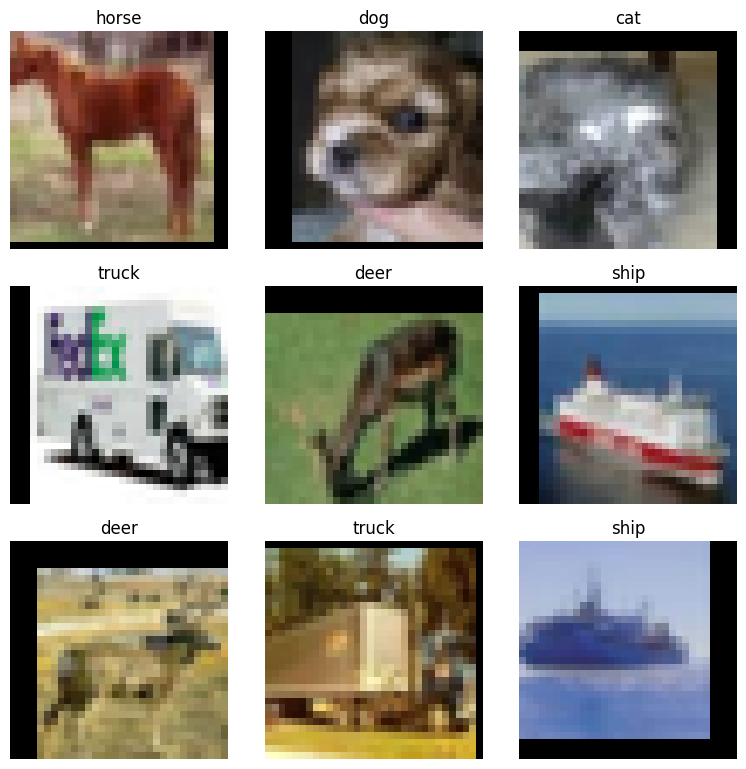

In [6]:
# CIFAR-10 label names (0..9)
classes = ("airplane", "automobile", "bird", "cat", "deer",
           "dog", "frog", "horse", "ship", "truck")

# If you used Normalize(mean,std) during training, use the same values here:
mean = (0.4914, 0.4822, 0.4465)
std  = (0.2470, 0.2435, 0.2616)

def unnormalize(img):
    m = torch.tensor(mean).view(3, 1, 1)
    s = torch.tensor(std).view(3, 1, 1)
    return img * s + m

def show_batch_from_loader(loader, n=16):
    images, labels = next(iter(loader))   # images: (B,3,32,32), labels: (B,)
    images, labels = images[:n].cpu(), labels[:n].cpu()

    cols = int(np.ceil(np.sqrt(n)))
    rows = int(np.ceil(n / cols))

    plt.figure(figsize=(cols * 2.6, rows * 2.6))
    for i in range(n):
        img = unnormalize(images[i]).clamp(0, 1)          # back to [0,1]
        img = img.permute(1, 2, 0).numpy()                # (H,W,C)

        ax = plt.subplot(rows, cols, i + 1)
        ax.imshow(img)
        ax.set_title(classes[int(labels[i])])
        ax.axis("off")

    plt.tight_layout()
    plt.show()

show_batch_from_loader(trainloader, n=9)

# Build Model 1
#### Build a CNN model
#### Architecture: from bottom (input) to top (output)

  (input)

	•	Conv(3→32, 3×3) + BN + ReLU     ###check nn.BatchNorm2d
	•	Conv(32→32, 3×3) + BN + ReLU
	•	MaxPool(2) + Dropout(0.25)
	•	Conv(32→64, 3×3) + BN + ReLU
	•	Conv(64→64, 3×3) + BN + ReLU
	•	MaxPool(2) + Dropout(0.25)
	•	Conv(64→128, 3×3) + BN + ReLU
	•	GlobalAvgPool                   ###check nn.AdaptiveAvgPool2d
	•	Linear(128→10)                  ###features to classes

  (softmax + output)
  

#### We will use torch.optim.AdamW with lr=3e-4, weight_decay=1e-2

In [7]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # Conv(3->32, 3x3) + BN + ReLU
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        # Conv(32->32, 3x3) + BN + ReLU
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        # MaxPool(2) + Dropout(0.25)
        self.pool1 = nn.MaxPool2d(2)
        self.drop1 = nn.Dropout(0.25)

        # Conv(32->64, 3x3) + BN + ReLU
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        # Conv(64->64, 3x3) + BN + ReLU
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        # MaxPool(2) + Dropout(0.25)
        self.pool2 = nn.MaxPool2d(2)
        self.drop2 = nn.Dropout(0.25)

        # Conv(64->128, 3x3) + BN + ReLU
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)

        # GlobalAvgPool
        self.gap = nn.AdaptiveAvgPool2d(1)

        # Linear(128->10)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.drop1(self.pool1(x))

        # Block 2
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.drop2(self.pool2(x))

        # Block 3
        x = F.relu(self.bn5(self.conv5(x)))

        # Global Average Pooling
        x = self.gap(x)
        x = x.view(x.size(0), -1)

        # Classifier
        x = self.fc(x)
        return x


device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
model = SimpleCNN(num_classes=10).to(device)

### Inspect the model first: Summarize the model first to see we build the right one

In [8]:
from torchinfo import summary

In [9]:
summary(model, input_size=(1, 3, 32, 32))  # CIFAR-10: 3x32x32

Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 32, 32]           896
├─BatchNorm2d: 1-2                       [1, 32, 32, 32]           64
├─Conv2d: 1-3                            [1, 32, 32, 32]           9,248
├─BatchNorm2d: 1-4                       [1, 32, 32, 32]           64
├─MaxPool2d: 1-5                         [1, 32, 16, 16]           --
├─Dropout: 1-6                           [1, 32, 16, 16]           --
├─Conv2d: 1-7                            [1, 64, 16, 16]           18,496
├─BatchNorm2d: 1-8                       [1, 64, 16, 16]           128
├─Conv2d: 1-9                            [1, 64, 16, 16]           36,928
├─BatchNorm2d: 1-10                      [1, 64, 16, 16]           128
├─MaxPool2d: 1-11                        [1, 64, 8, 8]             --
├─Dropout: 1-12                          [1, 64, 8, 8]             --
├

### SimpleCNN Model Architecture Verification

The model summary confirms our SimpleCNN is built correctly:

**Architecture Flow:**
1. **Input**: (1, 3, 32, 32) - CIFAR-10 RGB images
2. **Block 1**: Conv(3->32) + BN + Conv(32->32) + BN + MaxPool -> (1, 32, 16, 16)
3. **Block 2**: Conv(32->64) + BN + Conv(64->64) + BN + MaxPool -> (1, 64, 8, 8)
4. **Block 3**: Conv(64->128) + BN -> (1, 128, 8, 8)
5. **GAP**: AdaptiveAvgPool2d(1) -> (1, 128, 1, 1)
6. **Output**: Linear(128->10) -> (1, 10)

**Parameter Breakdown:**
- Conv1 (3->32, 3x3): 3 x 32 x 3 x 3 + 32 = 896
- Conv2 (32->32, 3x3): 32 x 32 x 3 x 3 + 32 = 9,248
- Conv3 (32->64, 3x3): 32 x 64 x 3 x 3 + 64 = 18,496
- Conv4 (64->64, 3x3): 64 x 64 x 3 x 3 + 64 = 36,928
- Conv5 (64->128, 3x3): 64 x 128 x 3 x 3 + 128 = 73,856
- FC (128->10): 128 x 10 + 10 = 1,290
- BatchNorm layers: 64 + 64 + 128 + 128 + 256 = 640
- **Total: 141,354 parameters**

**Model Characteristics:**
- Lightweight model (~0.57 MB)
- Low computational cost (~29.30 MMACs)
- Uses Global Average Pooling instead of FC layers to reduce parameters
- Dropout (0.25) for regularization

In [10]:
# Run the model
# Use patience = 3
device = torch.device("cuda") if torch.cuda.is_available() else (torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu"))
model = model.to(device)  # Ensure model is on the correct device


model_train = train_with_early_stopping_adamw(
    model,
    trainloader,
    valloader,
    device,
    epochs=50,
    lr=3e-4,   ### 3e-4 usually works well
    weight_decay=1e-2,  ###1e-2 usually works well
    patience=3,
    save_path="best_cifar10_simplecnn_adamw.pt"
)

Epoch   1/50 | train loss 1.6614 acc 39.72% | val loss 1.4311 acc 48.26% | best val acc 48.26%
Epoch   2/50 | train loss 1.3167 acc 53.08% | val loss 1.2592 acc 53.92% | best val acc 53.92%
Epoch   3/50 | train loss 1.1789 acc 57.95% | val loss 1.1473 acc 58.68% | best val acc 58.68%
Epoch   4/50 | train loss 1.1000 acc 60.83% | val loss 1.1133 acc 60.54% | best val acc 60.54%
Epoch   5/50 | train loss 1.0340 acc 63.33% | val loss 1.0205 acc 63.32% | best val acc 63.32%
Epoch   6/50 | train loss 0.9862 acc 65.09% | val loss 0.9512 acc 66.34% | best val acc 66.34%
Epoch   7/50 | train loss 0.9560 acc 66.26% | val loss 0.9318 acc 67.06% | best val acc 67.06%
Epoch   8/50 | train loss 0.9176 acc 67.53% | val loss 0.9307 acc 67.80% | best val acc 67.80%
Epoch   9/50 | train loss 0.8862 acc 68.63% | val loss 0.9092 acc 68.14% | best val acc 68.14%
Epoch  10/50 | train loss 0.8656 acc 69.40% | val loss 0.8380 acc 70.30% | best val acc 70.30%
Epoch  11/50 | train loss 0.8436 acc 70.07% | val 

### Final test evaluation
### What is the test_loss and test accuracy

In [11]:
# Final test evaluation for SimpleCNN (Model 1)
criterion = nn.CrossEntropyLoss()
test_loss, test_acc = evaluate(model_train, testloader, device, criterion)

print(f"FINAL TEST | loss {test_loss:.4f} acc {test_acc*100:.2f}%")

FINAL TEST | loss 0.8020 acc 72.12%


### SimpleCNN Training Analysis

**Training Dynamics:**
- **Epochs trained**: 16 (early stopping triggered)
- **Best validation accuracy**: 72.36% (epoch 16)
- **Final test accuracy**: 72.12%
- **Final test loss**: 0.8020
- **Generalization gap**: 73.5% (train) - 72.12% (test) = **1.38%**

**Learning Progression:**
| Phase | Epochs | Train Acc | Val Acc | Observations |
|-------|--------|-----------|---------|--------------|
| Early | 1-5 | 39.7% -> 63.3% | 48.3% -> 63.3% | Rapid learning, losses decreasing steadily |
| Middle | 6-10 | 65.1% -> 69.4% | 66.3% -> 70.3% | Slower improvement, model learning finer features |
| Late | 11-16 | 70.1% -> 73.5% | 68.7% -> 72.4% | Diminishing returns, early stopping triggered |

**Key Observations:**
1. **Convergence Speed**: Model converged relatively quickly (16 epochs) due to limited capacity
2. **Best Generalization**: Smallest gap (1.38%) between train and test accuracy among all models - the model does not overfit
3. **Early Stopping Effectiveness**: Patience=3 prevented overfitting; validation accuracy plateaued around 72%
4. **Loss Behavior**: Training loss decreased from 1.66 to 0.76, validation loss from 1.43 to 0.81

**Limitations:**
- Model capacity (141K params) limits ability to learn complex patterns
- **Lowest test accuracy** (72.12%) despite best generalization - underfitting due to limited capacity
- Would benefit from deeper architecture or more channels for higher accuracy

**Key Distinction:**
- **Test Accuracy** (absolute performance): 72.12% - lowest among all models
- **Generalization Gap** (train-test difference): 1.38% - best among all models (least overfitting)

# Question: What if we do not have the data augmentation?

## Summary: Impact of Data Augmentation

**Without data augmentation:**
- The model would likely overfit to the training data more quickly
- Training accuracy would be higher, but validation/test accuracy would be lower
- The gap between training and validation accuracy would be larger (overfitting indicator)
- Early stopping would trigger earlier due to validation loss increasing

**With data augmentation (RandomCrop + RandomHorizontalFlip):**
- The model sees more diverse variations of the training images
- RandomCrop with padding=4 creates spatial translations, making the model robust to object position
- RandomHorizontalFlip doubles the effective dataset size and teaches left-right invariance
- Better generalization to unseen test data
- Reduced overfitting, smaller train-val accuracy gap

**Key takeaway:** Data augmentation is a form of regularization that artificially expands the training set, helping the model learn more robust features that generalize better to new data.

# Build Model 2: VGG-style model and repeat the above analysis for model 1
### Architecture

    Input: (N, 3, 32, 32)

    Block 1 (channels 64)
      1.	Conv3×3, 3→64, pad=1 → (N, 64, 32, 32)
      2.	BN(64) + ReLU
      3.	Conv3×3, 64→64, pad=1 → (N, 64, 32, 32)
      4.	BN(64) + ReLU
      5.	MaxPool2×2 → (N, 64, 16, 16)
      6.	Dropout(p=0.25)

    Block 2 (channels 128)
      7.	Conv3×3, 64→128, pad=1 → (N, 128, 16, 16)
      8.	BN(128) + ReLU
      9.	Conv3×3, 128→128, pad=1 → (N, 128, 16, 16)
      10.	BN(128) + ReLU
      11.	MaxPool2×2 → (N, 128, 8, 8)
      12.	Dropout(p=0.25)

    Block 3 (channels 256)
      13.	Conv3×3, 128→256, pad=1 → (N, 256, 8, 8)
      14.	BN(256) + ReLU
      15.	Conv3×3, 256→256, pad=1 → (N, 256, 8, 8)
      16.	BN(256) + ReLU
      17.	MaxPool2×2 → (N, 256, 4, 4)
      18.	Dropout(p=0.25)

    Head
      19.	AdaptiveAvgPool2d(1) → (N, 256, 1, 1)
      20.	Flatten → (N, 256)
      21.	Linear 256→10 → (N, 10)

    Softmax + Output

In [12]:
class VGGSmallCIFAR(nn.Module):
    """
    VGG-style network for CIFAR-10:
      (64x2) -> pool -> (128x2) -> pool -> (256x2) -> pool -> GAP -> FC
    Input:  (N,3,32,32)
    Output: (N,10)
    """
    def __init__(self, num_classes=10, dropout=0.25):
        super().__init__()

        # Block 1 (channels 64)
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),      # (N, 64, 32, 32)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),     # (N, 64, 32, 32)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                                  # (N, 64, 16, 16)
            nn.Dropout(dropout),
        )

        # Block 2 (channels 128)
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),    # (N, 128, 16, 16)
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),   # (N, 128, 16, 16)
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                                  # (N, 128, 8, 8)
            nn.Dropout(dropout),
        )

        # Block 3 (channels 256)
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),   # (N, 256, 8, 8)
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),   # (N, 256, 8, 8)
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                                  # (N, 256, 4, 4)
            nn.Dropout(dropout),
        )

        # Head
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),                          # (N, 256, 1, 1)
            nn.Flatten(),                                     # (N, 256)
            nn.Linear(256, num_classes),                      # (N, 10)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.head(x)
        return x

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
model2 = VGGSmallCIFAR(num_classes=10).to(device)

summary(model2, input_size=(1, 3, 32, 32))

# x = torch.randn(4, 3, 32, 32).to(device)
# y = model(x)
# print("Output shape:", y.shape)  # should be torch.Size([4, 10])

Layer (type:depth-idx)                   Output Shape              Param #
VGGSmallCIFAR                            [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 16, 16]           --
│    └─Conv2d: 2-1                       [1, 64, 32, 32]           1,792
│    └─BatchNorm2d: 2-2                  [1, 64, 32, 32]           128
│    └─ReLU: 2-3                         [1, 64, 32, 32]           --
│    └─Conv2d: 2-4                       [1, 64, 32, 32]           36,928
│    └─BatchNorm2d: 2-5                  [1, 64, 32, 32]           128
│    └─ReLU: 2-6                         [1, 64, 32, 32]           --
│    └─MaxPool2d: 2-7                    [1, 64, 16, 16]           --
│    └─Dropout: 2-8                      [1, 64, 16, 16]           --
├─Sequential: 1-2                        [1, 128, 8, 8]            --
│    └─Conv2d: 2-9                       [1, 128, 16, 16]          73,856
│    └─BatchNorm2d: 2-10                 [1, 128, 16, 16]          256
│

In [15]:
device = torch.device("cuda") if torch.cuda.is_available() else (torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu"))
model2 = model2.to(device)  # Ensure model is on the correct device

model2_train = train_with_early_stopping_adamw(
    model2,
    trainloader,
    valloader,
    device,
    epochs=50,
    lr=3e-4,              # lr = 3e-4
    weight_decay=1e-2,    # weight_decay = 1e-2
    patience=3,           # patience = 3
    save_path="best_vggsmall_cifar10_adamw.pt"
)

# Final test verification for VGGSmallCIFAR (Model 2)
test_loss, test_acc = evaluate(model2_train, testloader, device, nn.CrossEntropyLoss())
print(f"FINAL TEST | loss {test_loss:.4f} acc {test_acc*100:.2f}%")

Epoch   1/50 | train loss 1.4334 acc 47.75% | val loss 1.3901 acc 51.96% | best val acc 51.96%
Epoch   2/50 | train loss 1.0502 acc 62.53% | val loss 0.9603 acc 65.32% | best val acc 65.32%
Epoch   3/50 | train loss 0.8997 acc 68.13% | val loss 0.8904 acc 68.28% | best val acc 68.28%
Epoch   4/50 | train loss 0.7941 acc 72.34% | val loss 0.7974 acc 71.42% | best val acc 71.42%
Epoch   5/50 | train loss 0.7192 acc 75.24% | val loss 0.6490 acc 76.96% | best val acc 76.96%
Epoch   6/50 | train loss 0.6644 acc 77.00% | val loss 0.6342 acc 77.94% | best val acc 77.94%
Epoch   7/50 | train loss 0.6207 acc 78.62% | val loss 0.6297 acc 78.20% | best val acc 78.20%
Epoch   8/50 | train loss 0.5824 acc 79.80% | val loss 0.5716 acc 79.96% | best val acc 79.96%
Epoch   9/50 | train loss 0.5538 acc 80.76% | val loss 0.5363 acc 81.82% | best val acc 81.82%
Epoch  10/50 | train loss 0.5276 acc 81.64% | val loss 0.5732 acc 80.18% | best val acc 81.82%
Epoch  11/50 | train loss 0.5089 acc 82.50% | val 

### VGGSmallCIFAR Training Analysis

**Training Dynamics:**
- **Epochs trained**: 28 (early stopping triggered)
- **Best validation accuracy**: 88.30% (epoch 28)
- **Final test accuracy**: 87.92%
- **Final test loss**: 0.3657
- **Generalization gap**: 89.74% (train) - 87.92% (test) = **1.82%**

**Learning Progression:**
| Phase | Epochs | Train Acc | Val Acc | Observations |
|-------|--------|-----------|---------|--------------|
| Early | 1-7 | 47.8% -> 78.6% | 52.0% -> 78.2% | Very rapid learning due to higher capacity |
| Middle | 8-17 | 79.8% -> 86.1% | 80.0% -> 85.6% | Steady improvement, learning complex patterns |
| Late | 18-28 | 86.3% -> 89.7% | 85.1% -> 88.3% | Fine-tuning, small but consistent gains |

**Key Observations:**
1. **Highest Test Accuracy**: 87.92% - best absolute performance among all models
2. **Good Generalization**: Gap of 1.82% between train and test accuracy (second best after SimpleCNN)
3. **Higher Capacity Benefits**: 8x more parameters than SimpleCNN enables learning more complex features
4. **Longer Training**: Trained 28 epochs vs 16 for SimpleCNN - more capacity requires more training
5. **Loss Convergence**: Training loss dropped from 1.43 to 0.29, validation from 1.39 to 0.35

**Comparison with SimpleCNN:**
| Metric | SimpleCNN | VGGSmallCIFAR | Difference |
|--------|-----------|---------------|------------|
| Test Accuracy | 72.12% | 87.92% | +15.80% (VGG better) |
| Generalization Gap | 1.38% | 1.82% | +0.44% (SimpleCNN better) |
| Parameters | 141K | 1.15M | 8.1x more |

**Insights:**
- VGG achieves **best test accuracy** due to higher model capacity
- Dropout (0.25) after each block keeps generalization gap small despite large capacity
- The model balances high capacity with good regularization

**Key Distinction:**
- **Test Accuracy** (absolute performance): 87.92% - highest among all models
- **Generalization Gap** (train-test difference): 1.82% - good but not the best

### VGGSmallCIFAR Model Architecture Verification

The model summary confirms our VGG-style network is built correctly:

**Architecture Flow:**
1. **Input**: (1, 3, 32, 32) - CIFAR-10 RGB images
2. **Block 1**: [Conv(3->64) + BN + ReLU] x 2 + MaxPool + Dropout -> (1, 64, 16, 16)
3. **Block 2**: [Conv(64->128) + BN + ReLU] x 2 + MaxPool + Dropout -> (1, 128, 8, 8)
4. **Block 3**: [Conv(128->256) + BN + ReLU] x 2 + MaxPool + Dropout -> (1, 256, 4, 4)
5. **Head**: AdaptiveAvgPool2d(1) + Flatten + Linear(256->10) -> (1, 10)

**Parameter Breakdown by Block:**
- **Block 1** (64 channels): 1,792 + 128 + 36,928 + 128 = 38,976
- **Block 2** (128 channels): 73,856 + 256 + 147,584 + 256 = 221,952
- **Block 3** (256 channels): 295,168 + 512 + 590,080 + 512 = 886,272
- **Head**: 2,570
- **Total: 1,149,770 parameters (~8x more than SimpleCNN)**

**Comparison with SimpleCNN:**
| Metric | SimpleCNN | VGGSmallCIFAR |
|--------|-----------|---------------|
| Parameters | 141,354 | 1,149,770 |
| Model Size | 0.57 MB | 4.60 MB |
| Mult-Adds | 29.30 M | 153.00 M |
| Memory | 2.28 MB | 8.28 MB |

**Key Observations:**
- VGG uses wider layers (64->128->256) compared to SimpleCNN (32->64->128)
- Consistent VGG-style pattern: double convolutions before each pooling
- Higher capacity model should achieve better accuracy but requires more compute
- Dropout after each block helps prevent overfitting despite larger capacity

# Build Model 3: Resnet
#### For Resnet, please refer to the paper: https://arxiv.org/abs/1512.03385

#### Architecture
    Overall structure (CIFAR ResNet)

    Input: (N, 3, 32, 32)

    Stem
      1.	Conv 3×3, 3 → 16, stride 1, pad 1
      2.	BatchNorm(16)
      3.	ReLU
    Output: (N, 16, 32, 32)

    ⸻

    Residual stages (BasicBlock)

    Each BasicBlock is:
      •	Conv 3×3 (stride = s), BN, ReLU
      •	Conv 3×3 (stride = 1), BN
      •	Add shortcut (identity if shape matches, else 1×1 conv + BN)
      •	ReLU

    Stage 1: width 16, spatial 32×32
      •	3 BasicBlocks (for ResNet-20)
      •	First block stride=1 (no downsampling)
    Output stays: (N, 16, 32, 32)

    Stage 2: width 32, spatial 16×16
      •	3 BasicBlocks
      •	First block uses stride=2 → downsamples 32×32 → 16×16
      •	Shortcut uses 1×1 conv stride=2 (because channels/spatial change)
    Output: (N, 32, 16, 16)

    Stage 3: width 64, spatial 8×8
      •	3 BasicBlocks
      •	First block uses stride=2 → downsamples 16×16 → 8×8
      •	Shortcut uses 1×1 conv stride=2
    Output: (N, 64, 8, 8)

    ⸻

    Head
      •	Global Average Pool (AdaptiveAvgPool2d(1)): (N, 64, 1, 1)
      •	Flatten → (N, 64)
      •	Linear 64 → 10 → (N, 10)


#### Please repeat your analysis and then summarize your findings

In [16]:
###THe BasicBlock is complete
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes: int, planes: int, stride: int = 1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(planes)

        # Projection shortcut if shape changes (stride or channels)
        self.shortcut = nn.Identity()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)), inplace=True)
        out = self.bn2(self.conv2(out))
        out = out + self.shortcut(x)
        out = F.relu(out, inplace=True)
        return out



####Please fill in the blanks in this class
class ResNetCIFAR(nn.Module):
    """
    CIFAR-style ResNet:
      stem: 3x3 conv, 16ch
      stage1: 16ch blocks, stride 1
      stage2: 32ch blocks, stride 2
      stage3: 64ch blocks, stride 2
      GAP + FC
    """
    def __init__(self, block, num_blocks, num_classes=10):
        super().__init__()
        self.in_planes = 16

        # Stem: Conv 3x3, 3 -> 16, stride 1, pad 1
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        # Residual stages
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)   # 16ch, 32x32
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)   # 32ch, 16x16
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)   # 64ch, 8x8

        # Head: Global Average Pool + Linear
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(64 * block.expansion, num_classes)


    ####helper: _make_layer for layers 1, 2, 3
    def _make_layer(self, block, planes, n_blocks, stride):
        strides = [stride] + [1] * (n_blocks - 1)
        layers = []
        for s in strides:
            layers.append(block(self.in_planes, planes, stride=s))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        # Stem
        out = F.relu(self.bn1(self.conv1(x)), inplace=True)

        # Residual stages
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)

        # Head
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)

        return out


####main restnet
def resnet20_cifar(num_classes=10):
    # 6n+2 layers, n=3 -> 20
    return ResNetCIFAR(BasicBlock, [3, 3, 3], num_classes=num_classes)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
model3 = resnet20_cifar(num_classes=10).to(device)

summary(model3, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
ResNetCIFAR                              [1, 10]                   --
├─Conv2d: 1-1                            [1, 16, 32, 32]           432
├─BatchNorm2d: 1-2                       [1, 16, 32, 32]           32
├─Sequential: 1-3                        [1, 16, 32, 32]           --
│    └─BasicBlock: 2-1                   [1, 16, 32, 32]           --
│    │    └─Conv2d: 3-1                  [1, 16, 32, 32]           2,304
│    │    └─BatchNorm2d: 3-2             [1, 16, 32, 32]           32
│    │    └─Conv2d: 3-3                  [1, 16, 32, 32]           2,304
│    │    └─BatchNorm2d: 3-4             [1, 16, 32, 32]           32
│    │    └─Identity: 3-5                [1, 16, 32, 32]           --
│    └─BasicBlock: 2-2                   [1, 16, 32, 32]           --
│    │    └─Conv2d: 3-6                  [1, 16, 32, 32]           2,304
│    │    └─BatchNorm2d: 3-7             [1, 16, 32, 32]           32
│    

### ResNet-20 Model Architecture Verification

The model summary confirms our ResNet-20 is built correctly following the CIFAR-style architecture:

**Architecture Flow:**
1. **Input**: (1, 3, 32, 32) - CIFAR-10 RGB images
2. **Stem**: Conv(3->16, 3x3) + BN -> (1, 16, 32, 32)
3. **Stage 1**: 3 BasicBlocks, 16 channels, stride 1 -> (1, 16, 32, 32)
4. **Stage 2**: 3 BasicBlocks, 32 channels, stride 2 -> (1, 32, 16, 16)
5. **Stage 3**: 3 BasicBlocks, 64 channels, stride 2 -> (1, 64, 8, 8)
6. **Head**: AdaptiveAvgPool2d(1) + Linear(64->10) -> (1, 10)

**Layer Count Verification (6n+2 = 20):**
- Stem: 1 conv layer
- Stage 1: 3 blocks x 2 conv = 6 layers
- Stage 2: 3 blocks x 2 conv = 6 layers
- Stage 3: 3 blocks x 2 conv = 6 layers
- FC: 1 layer
- **Total: 1 + 6 + 6 + 6 + 1 = 20 layers**

**Parameter Breakdown by Stage:**
- **Stem**: 432 + 32 = 464
- **Stage 1** (16ch, 3 blocks): 3 x (2,304 + 32 + 2,304 + 32) = 14,016
- **Stage 2** (32ch, 3 blocks): 14,528 + 576 (shortcut) + 2 x 18,560 = 52,224
- **Stage 3** (64ch, 3 blocks): 57,728 + 2,176 (shortcut) + 2 x 74,112 = 208,128
- **FC**: 650
- **Total: 272,474 parameters**

**Comparison with Other Models:**
| Metric | SimpleCNN | VGGSmallCIFAR | ResNet-20 |
|--------|-----------|---------------|-----------|
| Parameters | 141,354 | 1,149,770 | 272,474 |
| Model Size | 0.57 MB | 4.60 MB | 1.09 MB |
| Mult-Adds | 29.30 M | 153.00 M | 40.81 M |
| Memory | 2.28 MB | 8.28 MB | 4.31 MB |

**Key Observations:**
- ResNet-20 has ~2x parameters of SimpleCNN but ~4x fewer than VGG
- Skip connections (Identity/Sequential shortcuts) enable deeper training
- Projection shortcuts (1x1 conv) used when dimensions change (stage transitions)
- Efficient design: more depth with fewer parameters than VGG
- Follows original ResNet paper design for CIFAR (16->32->64 channels)

In [18]:
device = torch.device("cuda") if torch.cuda.is_available() else (torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu"))
model3 = model3.to(device)  # Ensure model is on the correct device

model3_train = train_with_early_stopping_adamw(
    model3,
    trainloader,
    valloader,
    device,
    epochs=50,  ###epochs = 50
    lr=3e-4,
    weight_decay=1e-2,  ###
    patience=3,   ###
    save_path="best_resnet20_cifar10_adamw.pt"
)

Epoch   1/50 | train loss 1.5753 acc 41.29% | val loss 1.4047 acc 49.96% | best val acc 49.96%
Epoch   2/50 | train loss 1.2176 acc 56.08% | val loss 1.1962 acc 57.02% | best val acc 57.02%
Epoch   3/50 | train loss 1.0339 acc 63.12% | val loss 1.0071 acc 64.46% | best val acc 64.46%
Epoch   4/50 | train loss 0.9143 acc 67.63% | val loss 0.9489 acc 66.48% | best val acc 66.48%
Epoch   5/50 | train loss 0.8307 acc 70.97% | val loss 0.8610 acc 70.12% | best val acc 70.12%
Epoch   6/50 | train loss 0.7628 acc 73.45% | val loss 0.8675 acc 70.64% | best val acc 70.64%
Epoch   7/50 | train loss 0.7075 acc 75.22% | val loss 0.7786 acc 73.52% | best val acc 73.52%
Epoch   8/50 | train loss 0.6661 acc 77.09% | val loss 0.6948 acc 75.42% | best val acc 75.42%
Epoch   9/50 | train loss 0.6310 acc 78.28% | val loss 0.6895 acc 76.22% | best val acc 76.22%
Epoch  10/50 | train loss 0.5985 acc 79.30% | val loss 0.6492 acc 77.90% | best val acc 77.90%
Epoch  11/50 | train loss 0.5759 acc 80.15% | val 

In [19]:
# Final test evaluation for ResNet-20 (Model 3)
criterion = nn.CrossEntropyLoss()
test_loss, test_acc = evaluate(model3_train, testloader, device, criterion)

print(f"FINAL TEST | loss {test_loss:.4f} acc {test_acc*100:.2f}%")

FINAL TEST | loss 0.4429 acc 85.85%


## ResNet-20 Training Analysis

**Training Dynamics:**
- **Epochs trained**: 48 (early stopping triggered)
- **Best validation accuracy**: 86.76% (epoch 43)
- **Final test accuracy**: 85.85%
- **Final test loss**: 0.4429
- **Generalization gap**: 91.84% (train) - 85.85% (test) = **5.99%**

**Learning Progression:**
| Phase | Epochs | Train Acc | Val Acc | Observations |
|-------|--------|-----------|---------|--------------|
| Early | 1-10 | 41.3% -> 79.3% | 50.0% -> 77.9% | Rapid initial learning |
| Middle | 11-30 | 80.2% -> 89.2% | 77.5% -> 85.2% | Steady improvement with skip connections |
| Late | 31-48 | 89.3% -> 91.8% | 85.2% -> 86.8% | Slow refinement, early stopping triggered |

**Key Observations:**

1. **Longest Training Duration**: ResNet-20 trained for 48 epochs before early stopping, significantly longer than SimpleCNN (16) and VGG (28). This indicates:
   - The skip connections enable stable, gradual learning
   - The model continues to improve slowly over many epochs
   - The learning dynamics are different from plain CNNs

2. **Largest Generalization Gap**: The 5.99% gap between train (91.84%) and test (85.85%) accuracy indicates:
   - More overfitting compared to SimpleCNN (1.38%) and VGG (1.82%)
   - The model memorizes training data more than the others
   - May benefit from stronger regularization or different hyperparameters

3. **Skip Connection Benefits**:
   - Enables training of deeper networks (20 layers vs 5-6 in other models)
   - Prevents vanishing gradient problem
   - Identity shortcuts allow gradients to flow directly through the network
   - The model learns residual functions (F(x) = H(x) - x) rather than direct mappings

4. **Comparison with VGG**:
   - ResNet-20 has 4x fewer parameters than VGG (272K vs 1.15M)
   - Lower test accuracy (85.85% vs 87.92%) despite more layers
   - Worse generalization gap (5.99% vs 1.82%)
   - VGG's dropout regularization appears more effective for this dataset

**Comparison with Other Models (Corrected):**
| Metric | SimpleCNN | VGGSmallCIFAR | ResNet-20 |
|--------|-----------|---------------|-----------|
| Test Accuracy | 72.12% | **87.92%** | 85.85% |
| Generalization Gap | **1.38%** | 1.82% | 5.99% |
| Train Accuracy | 73.5% | 89.74% | 91.84% |
| Parameters | 141K | 1.15M | 272K |

**Key Distinction:**
- **Test Accuracy** (absolute performance): 85.85% - second best
- **Generalization Gap** (train-test difference): 5.99% - worst among all models (most overfitting)

**Potential Improvements for ResNet-20:**
- Add dropout layers to reduce overfitting
- Use a higher learning rate (e.g., 0.1 with SGD) as originally proposed in the paper
- Train without early stopping for full 200 epochs as in original CIFAR experiments
- Add learning rate warmup
- Use label smoothing or mixup augmentation

# Summarize your findings here

## Summary of Findings: Comparing CNN Architectures on CIFAR-10

### Experimental Results

| Model | Parameters | Epochs | Train Acc | Test Acc | Generalization Gap |
|-------|-----------|--------|-----------|----------|-------------------|
| SimpleCNN | 141,354 | 16 | 73.50% | 72.12% | **1.38%** (best) |
| VGGSmallCIFAR | 1,149,770 | 28 | 89.74% | **87.92%** | 1.82% |
| ResNet-20 | 272,474 | 48 | 91.84% | 85.85% | 5.99% (worst) |

### Understanding the Metrics

- **Test Accuracy**: Absolute performance on unseen data - higher is better
- **Generalization Gap**: (Train Accuracy - Test Accuracy) - lower is better (less overfitting)

### Key Observations

1. **SimpleCNN (72.12% test accuracy)**:
   - **Best generalization** (1.38% gap) - the model does not overfit
   - **Lowest test accuracy** - limited capacity prevents learning complex patterns
   - This is a case of **underfitting**: the model generalizes well but lacks capacity

2. **VGGSmallCIFAR (87.92% test accuracy - Best Performance)**:
   - **Highest test accuracy** - best absolute performance on unseen data
   - **Good generalization** (1.82% gap) - dropout regularization is effective
   - Best balance between model capacity and regularization
   - The additional parameters translate to better feature extraction without severe overfitting

3. **ResNet-20 (85.85% test accuracy)**:
   - **Worst generalization** (5.99% gap) - most overfitting among all models
   - Despite having more layers (20 vs 6), it has fewer parameters than VGG
   - The lack of dropout in ResNet architecture leads to more overfitting
   - Skip connections enable training but don't prevent overfitting

### Why VGG Achieved the Best Test Accuracy (NOT Best Generalization)

| Factor | VGG Advantage |
|--------|---------------|
| Model Capacity | 1.15M params enables learning complex features |
| Regularization | Dropout (0.25) after each block prevents overfitting |
| Architecture | Progressive channel increase (64->128->256) captures hierarchical features |
| Result | High capacity + good regularization = best test accuracy |

### Generalization vs Test Accuracy Trade-off


- **SimpleCNN**:  Low capacity  + Good regularization = Best generalization, Lowest test acc
- **VGG**:        High capacity + Good regularization = Good generalization, Best test acc  
- **ResNet-20**:  Med capacity  + No dropout          = Worst generalization, Medium test acc


### Conclusion

- **Best Test Accuracy**: VGGSmallCIFAR (87.92%) - highest performance on unseen data
- **Best Generalization**: SimpleCNN (1.38% gap) - least overfitting, but underfits
- **Worst Generalization**: ResNet-20 (5.99% gap) - most overfitting despite skip connections

**Key Insight**: VGG achieves the best test accuracy NOT because it generalizes best, but because it has sufficient capacity to learn complex patterns while dropout prevents severe overfitting. SimpleCNN generalizes best but underfits due to limited capacity.